<a href="https://colab.research.google.com/github/ChrisKantor/Deep-Learning/blob/main/CV_Module_4_1_Image_Pyramid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021, Sudeep Sarkar, University of South Florida, Tampa

# Image Pyramids

* Image pyramids are a useful tool in the field of computer vision and image processing. The concept of a pyramid representation involves creating a **hierarchy of images**, each with a different **resolution or scale**, from a **single** input image. This representation is particularly valuable for tasks such as feature detection, computational efficiency, and is still widely used in modern deep learning architectures.

* In this lecture (also covered in Section 3.5 of the second edition of textbook), we will explore the basics of image pyramids and their applications. We will also delve into good filtering techniques for changing image resolution, such as **up-sampling (interpolation) and down-sampling (decimation)**, and their importance in the construction of an image pyramid.

* An image pyramid starts with the original resolution of the input image and gradually reduces its resolution through a process called down-sampling until the desired stopping size is reached. This hierarchy of images with varying resolutions is what makes image pyramids a powerful tool. The complete hierarchy of differently sized images allows for various applications, such as reducing and expanding image size, blending images, finding objects in an image, and fast matching of objects.

* Image pyramids play a crucial role in the field of computer vision and image processing. The ability to represent an image at multiple resolutions provides numerous benefits and makes it an important concept for anyone interested in this field to understand.


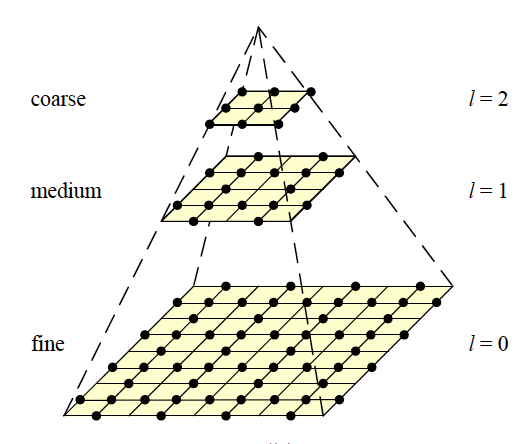

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.color import rgb2gray, rgba2rgb

from scipy import ndimage as scimage
# SciPy (pronounced “Sigh Pie”) is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
# https://www.scipy.org/

np.set_printoptions(precision=2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'

Mounted at /content/drive
 0005_Walking001.xlsx			     Fig3_4c.jpg        left11.jpg
 0008_ChaCha001.xlsx			     hawaii.png         left12.jpg
 2011_09_26_drive_0048_sync.zip		     house_1.png        lizard.jpg
 20211003_082148.jpg			     house_2.png        MOT16-08-raw.webm
 20211003_082201.jpg			     house_facade.png   mountain_peak_1.png
 apple.jpg				     images.zip         mountain_peak_2.png
'Armes 1.png'				     kellog.jpg         parking_lot_meva_1.png
'Armes 2.png'				     left01.jpg         parking_lot_meva_2.png
 blog_danforth_monica_mural_panorama.jpg     left02.jpg         parking_lot_meva_3.png
 blog_monica_mural_brown_white.jpg	     left03.jpg        'Road Signs Kaggle.zip'
 blog_monica_mural_fish_tree_windows1.jpg    left04.jpg         semper.zip
'cats and dogs.jpg'			     left05.jpg        'Superbowl 2021_1.png'
 convenience-store-cereal01.jpg		     left06.jpg        'Superbowl 2021_2.png'
 declaration_of_independence_stone_630.jpg   left07.jpg        'Superbowl 2021_3

# Useful python code snippets

In [3]:
# Example code to demonstrate an ability of python that we will use.
# Python snipet to generate (x, y) location/index pairs for all of the 12 pixels in an 4 by 3 image.

x, y = np.meshgrid(np.arange(3), np.arange(4))

print('x index is generated using np.arange(3)=', np.arange(3), '\ny index is generated using np.arange(4)=', np.arange(4), '\ny=', y.reshape(-1), '\nx=', x.reshape(-1))

x index is generated using np.arange(3)= [0 1 2] 
y index is generated using np.arange(4)= [0 1 2 3] 
y= [0 0 0 1 1 1 2 2 2 3 3 3] 
x= [0 1 2 0 1 2 0 1 2 0 1 2]


In [4]:
# Indexing -- negative indexing

# for arrays
a = np.array([1, 3, 4, 5])
print(a[-1], a[-2], a[-3], a[-4])
print(a[0], a[1], a[2], a[3])

# for lists
b = [1, 3, 4]
b.append(5)
print('\n', a[-1], a[-2], a[-3], a[-4])
print(a[0], a[1], a[2], a[3])

5 4 3 1
1 3 4 5

 5 4 3 1
1 3 4 5


In [5]:
def padded_add(a, b):
    # Returns the addition of arrays a and b, which can be of different sizes.
    # We pad a and b with additional zero-valued rows and columns to make them of the same size.
    # The output size is the maximum of two arrays.
    # You can use this to also subtract two arrays of different sizes -- just pass -b instead of b.

    h1, w1 = a.shape
    h2, w2 = b.shape
    h_max = max(h1, h2)
    w_max = max(w1, w2)

    a_padded = np.pad(a, ((0, h_max - h1), (0, w_max - w1)), 'constant')
    b_padded = np.pad(b, ((0, h_max - h2), (0, w_max - w2)), 'constant')

    return a_padded + b_padded

A = np.array([[1, 1], [2, 2], [3, 3]])
B = np.array([[1, 1, 2], [2, 2, 2]])

print("A=\n", A)
print("B=\n", B)
print("A+B=\n", padded_add(A, B))
print("A-B=\n", padded_add(A, -B))

A=
 [[1 1]
 [2 2]
 [3 3]]
B=
 [[1 1 2]
 [2 2 2]]
A+B=
 [[2 2 2]
 [4 4 2]
 [3 3 0]]
A-B=
 [[ 0  0 -2]
 [ 0  0 -2]
 [ 3  3  0]]


# Image pyramid construction by downsampling and upsampling using splines

* An image pyramid, denoted as ${I_0, I_1 \cdots, I_n }$, is a multi-resolution representation of an image, where $I_0$ is the input image and $I_n$ is the smallest representation of the image at the topmost of the pyramid.

* The downsampling process can be mathematically represented as $(I_{l}\downarrow_2)$. The ratio of the size of $I_l$ to the size of $I_{l+1}$ is typically 2, which means that the size of the image reduces by half as we move up the pyramid.

* This downsampling process can involve some form of interpolation, like what we have seen in the image warping function.

* The (up) pyramid representation can be created by downsampling and represented as follows
\begin{eqnarray}
I_1 & =  & I_0\downarrow_2 \\
I_2 & =  & I_1\downarrow_2 \\
\vdots & & \vdots \\
I_ n& =  & I_{n-1}\downarrow_2
\end{eqnarray}

* We construct the (down) pyramid starting from $I_n$ and upsampling the image at the previous level from the (up) pyramid. Let the (down) pyramid be represented by $\{J_0, J_1, \cdots, J_n \}$, with $J_n=I_n$.

* We will denote the upsampling operation by a factor of 2 by $(I_{l}\uparrow^2)$.

* Thus the (down) pyramid representation can be created by upsampling as follows
\begin{eqnarray}
J_n & =  & I_n \\
J_{n-1} & =  & I_n\uparrow^2 \\
J_{n-2} & = & I_{n-1}\uparrow^2 \\
\vdots & & \vdots \\
J_ 0& =  & I_{1}\uparrow^2
\end{eqnarray}

* In practice, there are several interpolation techniques that can be used to perform downsampling and upsampling operations in an image pyramid. For example, Scikit's spline-based method is a commonly used technique.

* An example image pyramid (up and down) can be seen in the code below, which demonstrates the process of constructing a pyramid and the difference between the images at the same level in the up and down pyramids.

## Code: (up) and (down) pyramids


# Levels of (up) pyramid= 6 
# Levels of (down) pyramid= 6 
# Levels of pyramid= 6


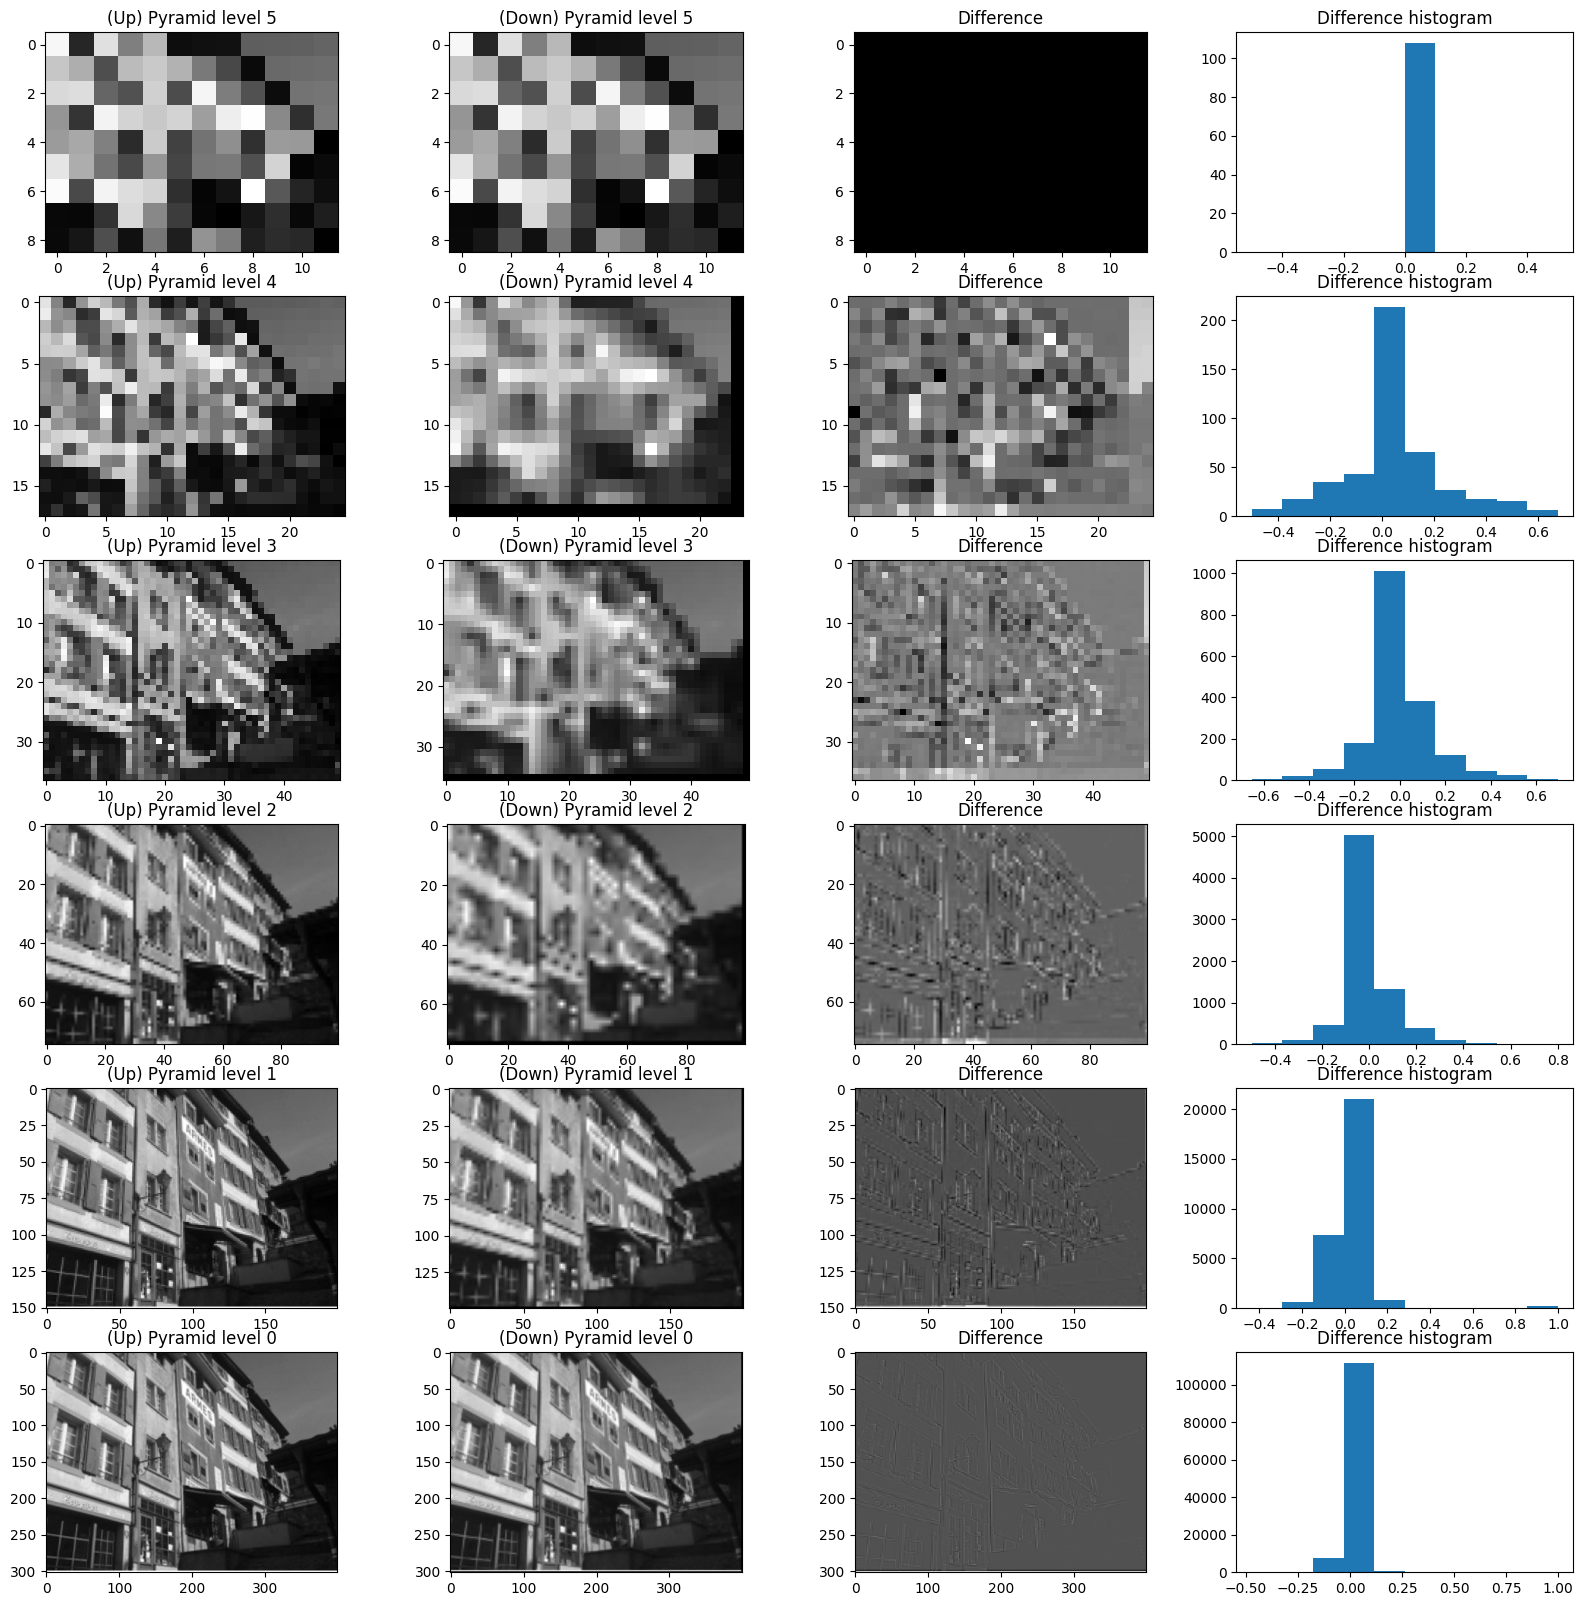

In [6]:
import scipy.ndimage as scimage
import numpy as np

def scale_image(in_image, scale, sample_order):
    """
    Scales the size of an input image using a specified scale factor and order of spline interpolation.

    in_image: Input 2D array representing the image to be scaled.
    scale: The factor by which the image should be scaled.
    sample_order: The order of the spline interpolation.
    return - The scaled image as a 2D array.
    """
    # Calculate the output image dimensions
    height, width = in_image.shape
    height_out = int(height * scale)
    width_out = int(width * scale)

    # Initialize the output image array with zeros
    out_image = np.zeros((height_out, width_out))

    # Create meshgrid for coordinates
    y, x = np.meshgrid(np.arange(height_out), np.arange(width_out))

    # Adjust the coordinates based on the scaling factor
    fx = x/scale
    fy = y/scale

    # Map the input image's coordinates to the output image
    values = scimage.map_coordinates(in_image, [fy, fx], order=sample_order)

    # Assign the interpolated values to the output image
    out_image[y, x] = values

    return out_image

# Load an image in grayscale
img = io.imread(data_dir + 'Armes 1.png')
img = rgb2gray(rgba2rgb(img))

# Define the number of levels in the pyramid and the scaling factor
num_levels = 6
factor = 2.0

# Create the up pyramid (reducing the image size)
up_pyramid = [img]
for i in range(1, num_levels):
    # Scale down the image and append to the pyramid
    up_pyramid.append(scale_image(up_pyramid[-1], scale=1/factor, sample_order=1))

# Create the down pyramid (increasing the image size)
down_pyramid = [up_pyramid[-1]]
for i in range(1, num_levels):
    # Scale up the image and append to the pyramid
    down_pyramid.append(scale_image(up_pyramid[num_levels - i], scale=factor, sample_order=1))

# Output the number of levels in the pyramids
print('\n# Levels of (up) pyramid=', len(up_pyramid),
      '\n# Levels of (down) pyramid=', len(down_pyramid),
      '\n# Levels of pyramid=', num_levels)

# Plotting the pyramids and the difference between levels
fig, axs = plt.subplots(nrows=num_levels, ncols=4)
fig.set_size_inches(20, 20)

# Display each level of the up and down pyramids
for i in range(num_levels):
    axs[i, 0].imshow(up_pyramid[-(i+1)], 'gray')
    axs[i, 0].set_title('(Up) Pyramid level {}'.format(num_levels - i - 1))

    axs[i, 1].imshow(down_pyramid[i], 'gray')
    axs[i, 1].set_title('(Down) Pyramid level {}'.format(num_levels - 1 - i))

    # Compute and display the error between corresponding levels of the two pyramids
    reconstruction_error = padded_add(up_pyramid[-(i+1)], -down_pyramid[i])
    axs[i, 2].imshow(reconstruction_error, 'gray')
    axs[i, 3].hist(reconstruction_error.reshape(-1))
    axs[i, 2].set_title('Difference')
    axs[i, 3].set_title('Difference histogram')

# NOTE: We use the up pyramid images when we are creating the down pyramid. ie down pyramid i is derived from up pyramid i + 1. for down pyramid n, we copy up pyramid n. If we just used the down pyramid images to upscale we would loose a lot of detail

# Assignment: Order of interpolation

Try changing the order of interpolation used during sampling in the above code and describe the change in the error of the reconstructed images.

# Difference image pyramid representation

* The difference image pyramid, $\{D_0, D_1, \dots, D_n\}$, has its top-level image same as the top-level representation of the original image pyramid, i.e., $D_n = J_n = I_n$ (The lowest resolution). The rest of the pyramid is the difference (error) images we have seen earlier.

* Thus, the difference-pyramid images are as follows:

\begin{eqnarray}
D_n & =  & I_n \\
D_{n-1} & =  & I_{n-1} - (I_{n}\uparrow^2) \\
\vdots & & \vdots \\
D_ 0& =  & I_{0} - (I_{1}\uparrow^2)
\end{eqnarray}

* The original image can be reconstructed using this difference-image pyramid as follows.

\begin{eqnarray}
\hat{I}_n & =  & D_n \\
\hat{I}_{n-1} & =  & D_{n-1} + (\hat{I}_{n}\uparrow^2) \\
\vdots & & \vdots \\
\hat{I}_0& =  & D_{0} + (\hat{I}_{1}\uparrow^2)
\end{eqnarray}

ie upscaling a layer of the difference pyramid and addng the next layer to it


## Code: Difference Pyramid and reconstructing the image

Level= 1 up_pyramid shape =  (18, 25) down_pyramid shape =  (18, 24)
Level= 2 up_pyramid shape =  (37, 50) down_pyramid shape =  (36, 50)
Level= 3 up_pyramid shape =  (75, 100) down_pyramid shape =  (74, 100)
Level= 4 up_pyramid shape =  (151, 200) down_pyramid shape =  (150, 200)
Level= 5 up_pyramid shape =  (302, 400) down_pyramid shape =  (302, 400)


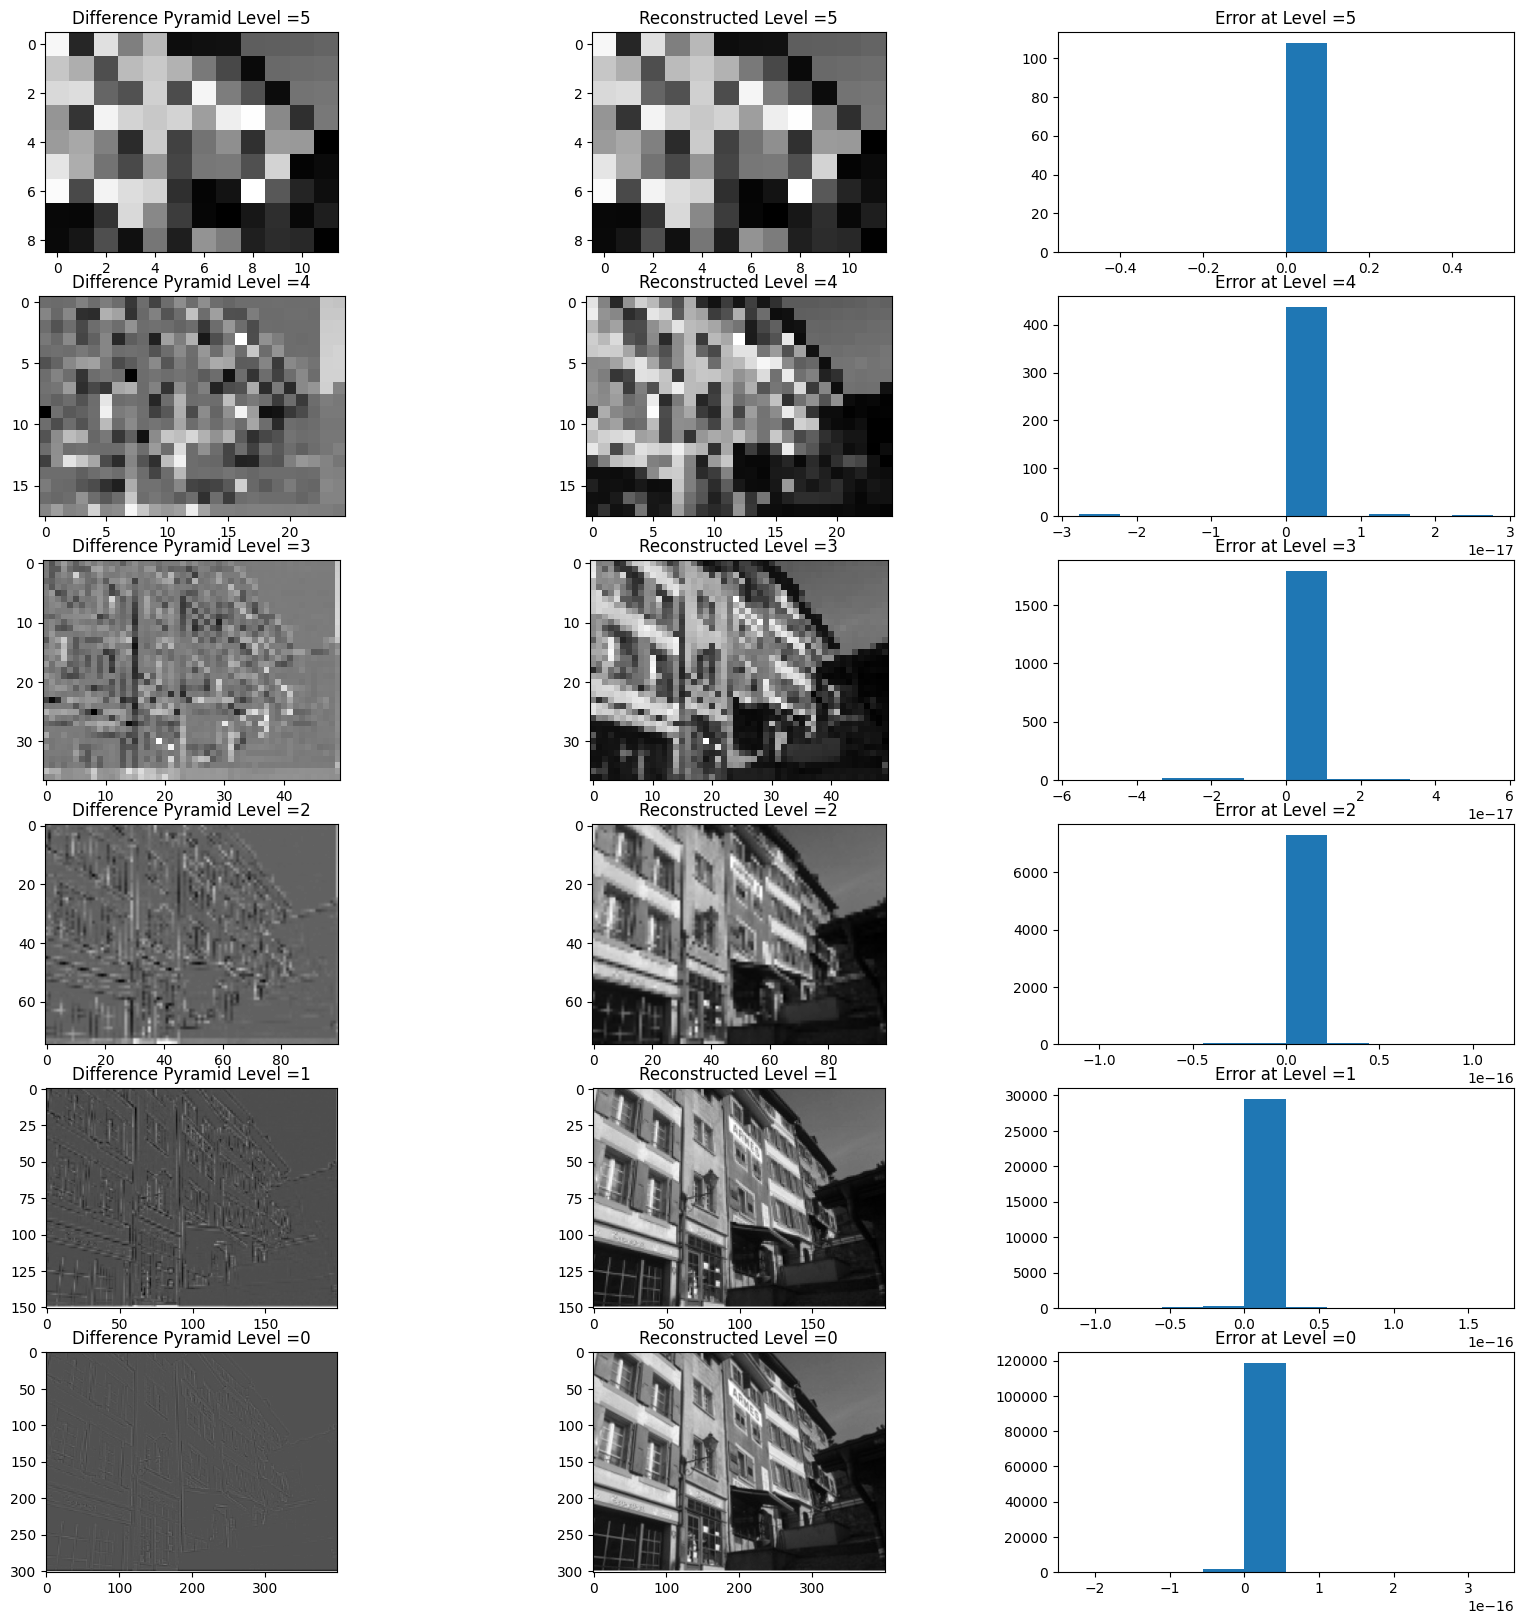

In [7]:
# The Difference Pyramid is composed of the difference between the images at the
# corresponding levels of the up- and down- pyramid, except for the top-most level,
# which is the same as the top-most of the up-pyramid.

difference_pyramid = []
# Append the smallest image (top of the up-pyramid) as the first level of the difference pyramid
difference_pyramid.append(up_pyramid[-1])

# Iterate through the levels of the pyramids to compute the difference images
for i in range(1, num_levels):
    # Print the shape of the current level of up and down pyramids for debugging purposes
    print('Level=', i, 'up_pyramid shape = ', up_pyramid[-(i+1)].shape, 'down_pyramid shape = ', down_pyramid[i].shape)

    # Compute the difference between the corresponding levels of the up and down pyramids
    diff_im = padded_add(up_pyramid[-(i+1)], -down_pyramid[i])
    # Append the difference image to the difference pyramid
    difference_pyramid.append(diff_im)

# Reconstruct the image up-pyramid
I_hat_pyramid = []
# Initialize the reconstructed pyramid with the smallest image (top of the difference pyramid)
I_hat_pyramid.append(difference_pyramid[0])

# Iterate through the levels to reconstruct the images
for i in range(1, num_levels):
    # Upscale the previous reconstructed image
    up_scaled_im = scale_image(I_hat_pyramid[i-1], scale=factor, sample_order=1)
    # Add the difference image to the upscaled image to reconstruct the current level image
    reconstructed_image = padded_add(up_scaled_im, difference_pyramid[i])
    # Append the reconstructed image to the reconstructed pyramid
    I_hat_pyramid.append(reconstructed_image)

#------------------display-----------------------------------------

# Set up the figure for visualizing the difference pyramid, the reconstructed pyramid, and the error
fig, axs = plt.subplots(nrows=num_levels, ncols=3)  #, sharex=True, sharey=True)
fig.set_size_inches(20, 20)

# Iterate through the levels to display the difference images, reconstructed images, and the error histograms
for i in range(num_levels):
    # Display the difference image
    axs[i, 0].imshow(difference_pyramid[i], 'gray')
    axs[i, 0].set_title('Difference Pyramid Level ={}'.format(num_levels - i - 1))

    # Display the reconstructed image
    axs[i, 1].imshow(I_hat_pyramid[i], 'gray')
    axs[i, 1].set_title('Reconstructed Level ={}'.format(num_levels - i - 1))

    # Compute and display the error histogram between the original up-pyramid and the reconstructed pyramid
    axs[i, 2].hist((up_pyramid[-(i+1)] - I_hat_pyramid[i]).reshape(-1))
    axs[i, 2].set_title('Error at Level ={}'.format(num_levels - i - 1))

# Assignment: Difference Pyramid

For an image in the collection provided for this course, construct two difference-pyramids. The first pyramid should have 4 levels and the second should have 8 levels. Analyze the results of each pyramid and discuss how you can utilize them to compress the image, i.e. reduce the file size of the image stored on disk. Submit your report on the Canvas platform.




## Code: create_difference_pyramid function

This function creates a difference pyramid by computing the difference between corresponding levels of the up and down pyramids. The top-most level of the up-pyramid is used directly as the top-most level of the difference pyramid, as there's no corresponding level in the down-pyramid to compare it with. The function also includes error handling to ensure that the up and down pyramids are of the same size.

In [8]:
def create_difference_pyramid(up_pyramid, down_pyramid):
    """
    Creates a difference pyramid by calculating the difference between corresponding
    levels of the up and down pyramids.

    up_pyramid: List of images representing the up pyramid (small to large).
    down_pyramid: List of images representing the down pyramid (small to large).
    return - The difference pyramid as a list of images or 0 in case of error.
    """
    # Check if the up and down pyramids have the same number of levels
    if len(up_pyramid) != len(down_pyramid):
        print('Error -- the up and down pyramids are of different heights')
        return 0  # Return 0 to indicate an error

    nlevels = len(up_pyramid)  # Number of levels in the pyramids
    difference_pyramid = []  # Initialize the difference pyramid list

    # Append the top-most level of the up pyramid directly to the difference
    # pyramid (no difference calculation needed)
    difference_pyramid.append(up_pyramid[-1])

    # Calculate the difference for each level in the pyramids, starting from the smallest level
    for i in range(1, nlevels):
        # Compute the difference between the corresponding levels of the up and down pyramids
        # Assuming `padded_add` is a function that adds two images, handling dimensions and padding if necessary
        diff_im = padded_add(up_pyramid[-(i+1)], -down_pyramid[i])

        # Append the difference image to the difference pyramid
        difference_pyramid.append(diff_im)

    return difference_pyramid  # Return the constructed difference pyramid

# Upsampling using convolutions


image.png

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

Note: We are trying to estimate the red line given the f(k + #) points using convolutions.
to solve for any point on the red line, add all of the blue values at that point together.

* We can implement the interpolation (upsampling) as a convolution function.

* The above figure is an illustration. Imagine the kernel function $h()$ placed at each sample of the $f()$ function, scaled by the corresponding value of the function. The output is the sum of all these functions.

* In 2D, this function will be

\begin{equation}
g(i, j) = \sum_{k, l} f(k, l) h(i - rk, j - rl)
\end{equation}

* This equation is similar to the convolution equation, except for the multiplication of the $k$ and $l$ indices using $r$.

* For upsampling by a factor of 2, this equation is the following. Note we are considering every other sample of the $h$ function.

\begin{equation}
g(i, j) = \sum_{k, l} f(k, l) h(i - 2k, j - 2l)
\end{equation}

* The above is equivalent to the following

\begin{equation}
g(i, j) = \sum_{k, l} f'(k, l) h(i - k, j - l)
\end{equation}

> where $f'(k, l)$ is constructed out of $f(k, l)$ by inserting zeros between adjacent samples.


* Commonly used interpolating kernels are separable, i.e. the 2D version of the kernel is a product of the 1D versions, just the Gaussian filter $g(x, y) = g(x) g(y)$

* For instance, the 2D Box-3 function
\begin{equation}
h  = \frac{1}{9} \begin{bmatrix} 1 & 1 & 1 \\ 1 & 1 & 1\\ 1 & 1 & 1 \end{bmatrix}
\end{equation}

> is a product of 1D Box-3 filters as follows
\begin{equation}
h  = \left ( \frac{1}{3} \begin{bmatrix} 1  \\ 1 \\ 1  \end{bmatrix} \right )
     \left ( \frac{1}{3} \begin{bmatrix} 1  & 1 & 1  \end{bmatrix} \right )
\end{equation}

> where the 1D Box-3 filter is given by $ \frac{1}{3} \begin{bmatrix} 1  & 1 & 1  \end{bmatrix} $

* Other choices of the interpolating filter are below.

* Nice illustration of the different interpolations in 2D are in https://en.wikipedia.org/wiki/Bilinear_interpolation






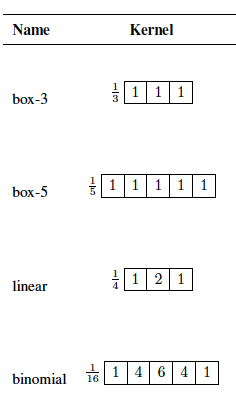

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

## Code: Study of box, linear, binomial, Gaussian filters

In [9]:
import scipy.signal

box_2 = np.array([[1, 1]])
linear = scipy.signal.convolve (box_2, box_2)
binomial = scipy.signal.convolve (linear, linear)
print('linear fiter {} is convolution of box-2 filter {} with itself'.format(linear, box_2))

print('The 2D version is the bilinear fiter \n{}'.format(np.transpose(linear)@linear))

print('binomial fiter {} is convolution of linear filter {} with itself'.format(binomial, linear))

gaussian = scipy.signal.gaussian(5, 1)
print('Gaussian filter (sigma = 1) is similar to binomial filter', gaussian/gaussian[0])


linear fiter [[1 2 1]] is convolution of box-2 filter [[1 1]] with itself
The 2D version is the bilinear fiter 
[[1 2 1]
 [2 4 2]
 [1 2 1]]
binomial fiter [[1 4 6 4 1]] is convolution of linear filter [[1 2 1]] with itself
Gaussian filter (sigma = 1) is similar to binomial filter [1.   4.48 7.39 4.48 1.  ]


<ipython-input-9-2dd4843fafc4>:12: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian = scipy.signal.gaussian(5, 1)


## Code: up_sample function

In [10]:
#----------up sampling using convolution--------------------------------
def up_sample (a, kernel) :
    # up samples an array into double the size using convolution with kernel k
    m,n = a.shape
    a_prime = np.zeros((2*m,2*n),dtype=a.dtype)
    a_prime[::2,::2] = a # the array a_prime is now a zero padded version of a
    out = scipy.signal.convolve2d(a_prime, kernel, mode = 'same')
    return(out, a_prime)

## Code: (down) pyramid using convolutions

1D linear interpolator [[0.5 1.  0.5]]
2D bi-linear interpolator
 [[0.25 0.5  0.25]
 [0.5  1.   0.5 ]
 [0.25 0.5  0.25]]
Height of (up) pyramid 6


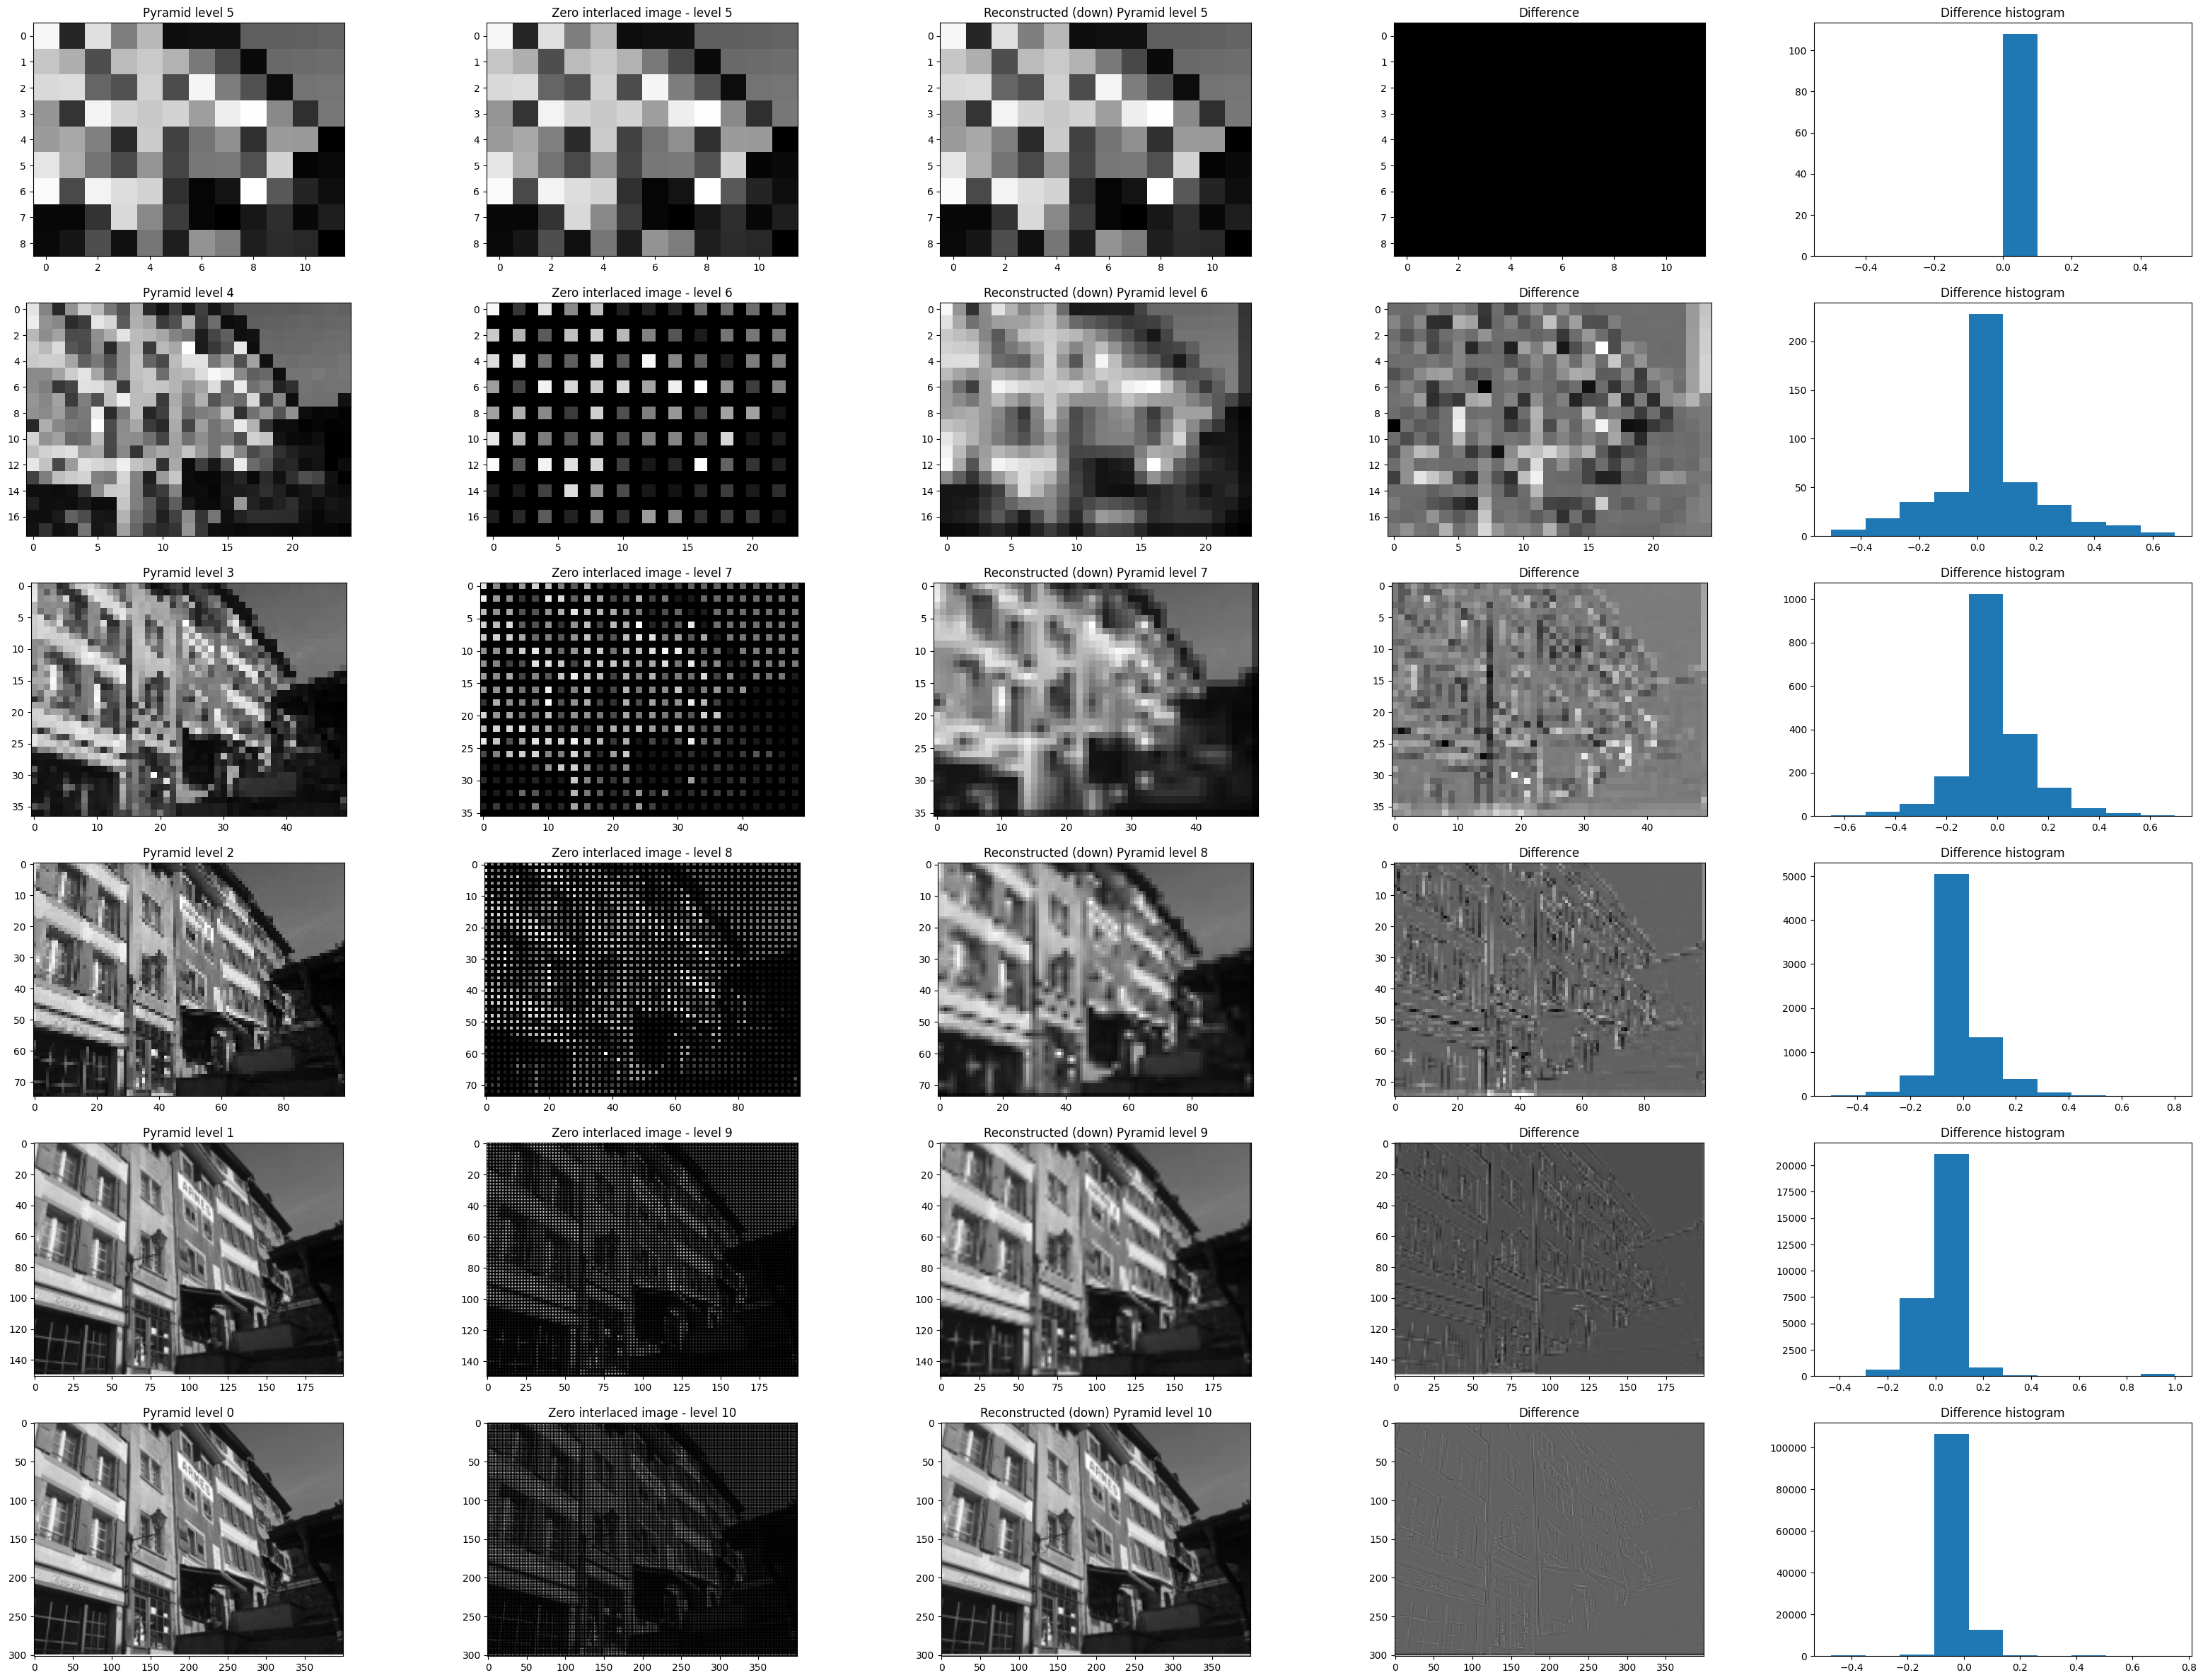

In [11]:
import scipy.signal

#--------------------------------------------------------------------------
factor = 2;  # upsampling ratio
h   = scipy.signal.convolve2d(np.ones((1, factor)),np.ones((1, factor)))/factor;  # 1D linear interpolator (triangle, plot it and see).
hBL = h.transpose()*h;      # 2D bi-linear interpolator.

print('1D linear interpolator', h)
print('2D bi-linear interpolator\n', hBL)
print('Height of (up) pyramid', len(up_pyramid))
num_levels = len(up_pyramid)

# Create the (down) pyramid by upscaling from the image from the previous level of (up) pyramid
down_pyramid = []
f_prime = [] # stores the zero padded array -- used just for visualization
down_pyramid.append(up_pyramid[-1])
f_prime.append(up_pyramid[-1])

for i in range (1, num_levels) :
    temp_a, temp_b = up_sample(up_pyramid[-i], hBL)
    #print(len(up_pyramid), i, num_levels)
    down_pyramid.append(temp_a)
    f_prime.append(temp_b)

#------------------display-----------------------------------------

fig, axs = plt.subplots(nrows=num_levels, ncols=5)

fig.set_size_inches (40, 30)

for i in range (num_levels) :
    axs[i, 0].imshow(up_pyramid[-(i+1)], 'gray')
    axs[i, 0].set_title('Pyramid level {}'.format(num_levels-i-1))

for i in range (num_levels) :
    axs[i, 1].imshow(f_prime[i], 'gray')
    axs[i, 1].set_title('Zero interlaced image - level {}'.format(i+num_levels-1))


for i in range (num_levels) :
    axs[i, 2].imshow(down_pyramid[i], 'gray')
    axs[i, 2].set_title('Reconstructed (down) Pyramid level {}'.format(i+num_levels-1))


for i in range (num_levels) :
    reconstruction_error = padded_add(up_pyramid[-(i+1)], -down_pyramid[i])
    axs[i, 3].imshow(reconstruction_error, 'gray')
    axs[i, 3].set_title('Difference')
    axs[i, 4].hist(reconstruction_error.reshape(-1))
    axs[i, 4].set_title('Difference histogram')


## Code: create_down_pyramid function

In [12]:
# Codified the down pyramid construction as a function
def create_down_pyramid (pyramid, kernel) :
    # Create the (down) pyramid by upscaling from the image from the previous level of (up) pyramid using kernel
    nlevels = len(pyramid)
    down_pyramid = []
    down_pyramid.append(pyramid[-1])
    for i in range (1, nlevels) :
        temp_a, _ = up_sample(pyramid[-(i)], kernel)
        down_pyramid.append(temp_a)
    return(down_pyramid)



# Downsampling using convolutions

* The current strategy of reducing the size essentially picks every other pixel to reduce the image size. This type of simple reduction in size introduces an effect called *aliasing*. For an illustration of the aliasing effect, note the ragged nature of the building edges.

* A better strategy is to smooth the image (or low-pass filter it) and select a subsample.

* Convolve with $h()$ and then sample every $r$-th pixel

\begin{equation}
g(i, j) = \sum_{k, l} f(k, l) h(ri - k, rj - l)
\end{equation}

* One typical filter used is the Gaussian filter, thus creating the **Gaussian Pyramid**.

* Approximations versions of the Gaussian filters are also in use.

## Code: create_up_pyramid function

In [13]:
def create_up_pyramid (image, kernel, nlevels) :
    # Create image (up) pyramid by downscaling the image by factor using a 2D kernel k
    pyramid = []
    pyramid.append(image)
    for i in range (1, nlevels) :
        kernel_smoothed = scipy.signal.convolve2d(pyramid[-1], kernel, mode = 'same')
        pyramid.append(kernel_smoothed[::2,::2])

    return(pyramid)

## Code: (up) pyramid using smoothing convolutions

Binomial kernel of Burt and Adelson (approximately Gaussian)
 [[0.   0.02 0.02 0.02 0.  ]
 [0.02 0.06 0.09 0.06 0.02]
 [0.02 0.09 0.14 0.09 0.02]
 [0.02 0.06 0.09 0.06 0.02]
 [0.   0.02 0.02 0.02 0.  ]] 1.0
Burt and Adelson Binomial interpolator
 [[0.02 0.06 0.09 0.06 0.02]
 [0.06 0.25 0.38 0.25 0.06]
 [0.09 0.38 0.56 0.38 0.09]
 [0.06 0.25 0.38 0.25 0.06]
 [0.02 0.06 0.09 0.06 0.02]] 4.0


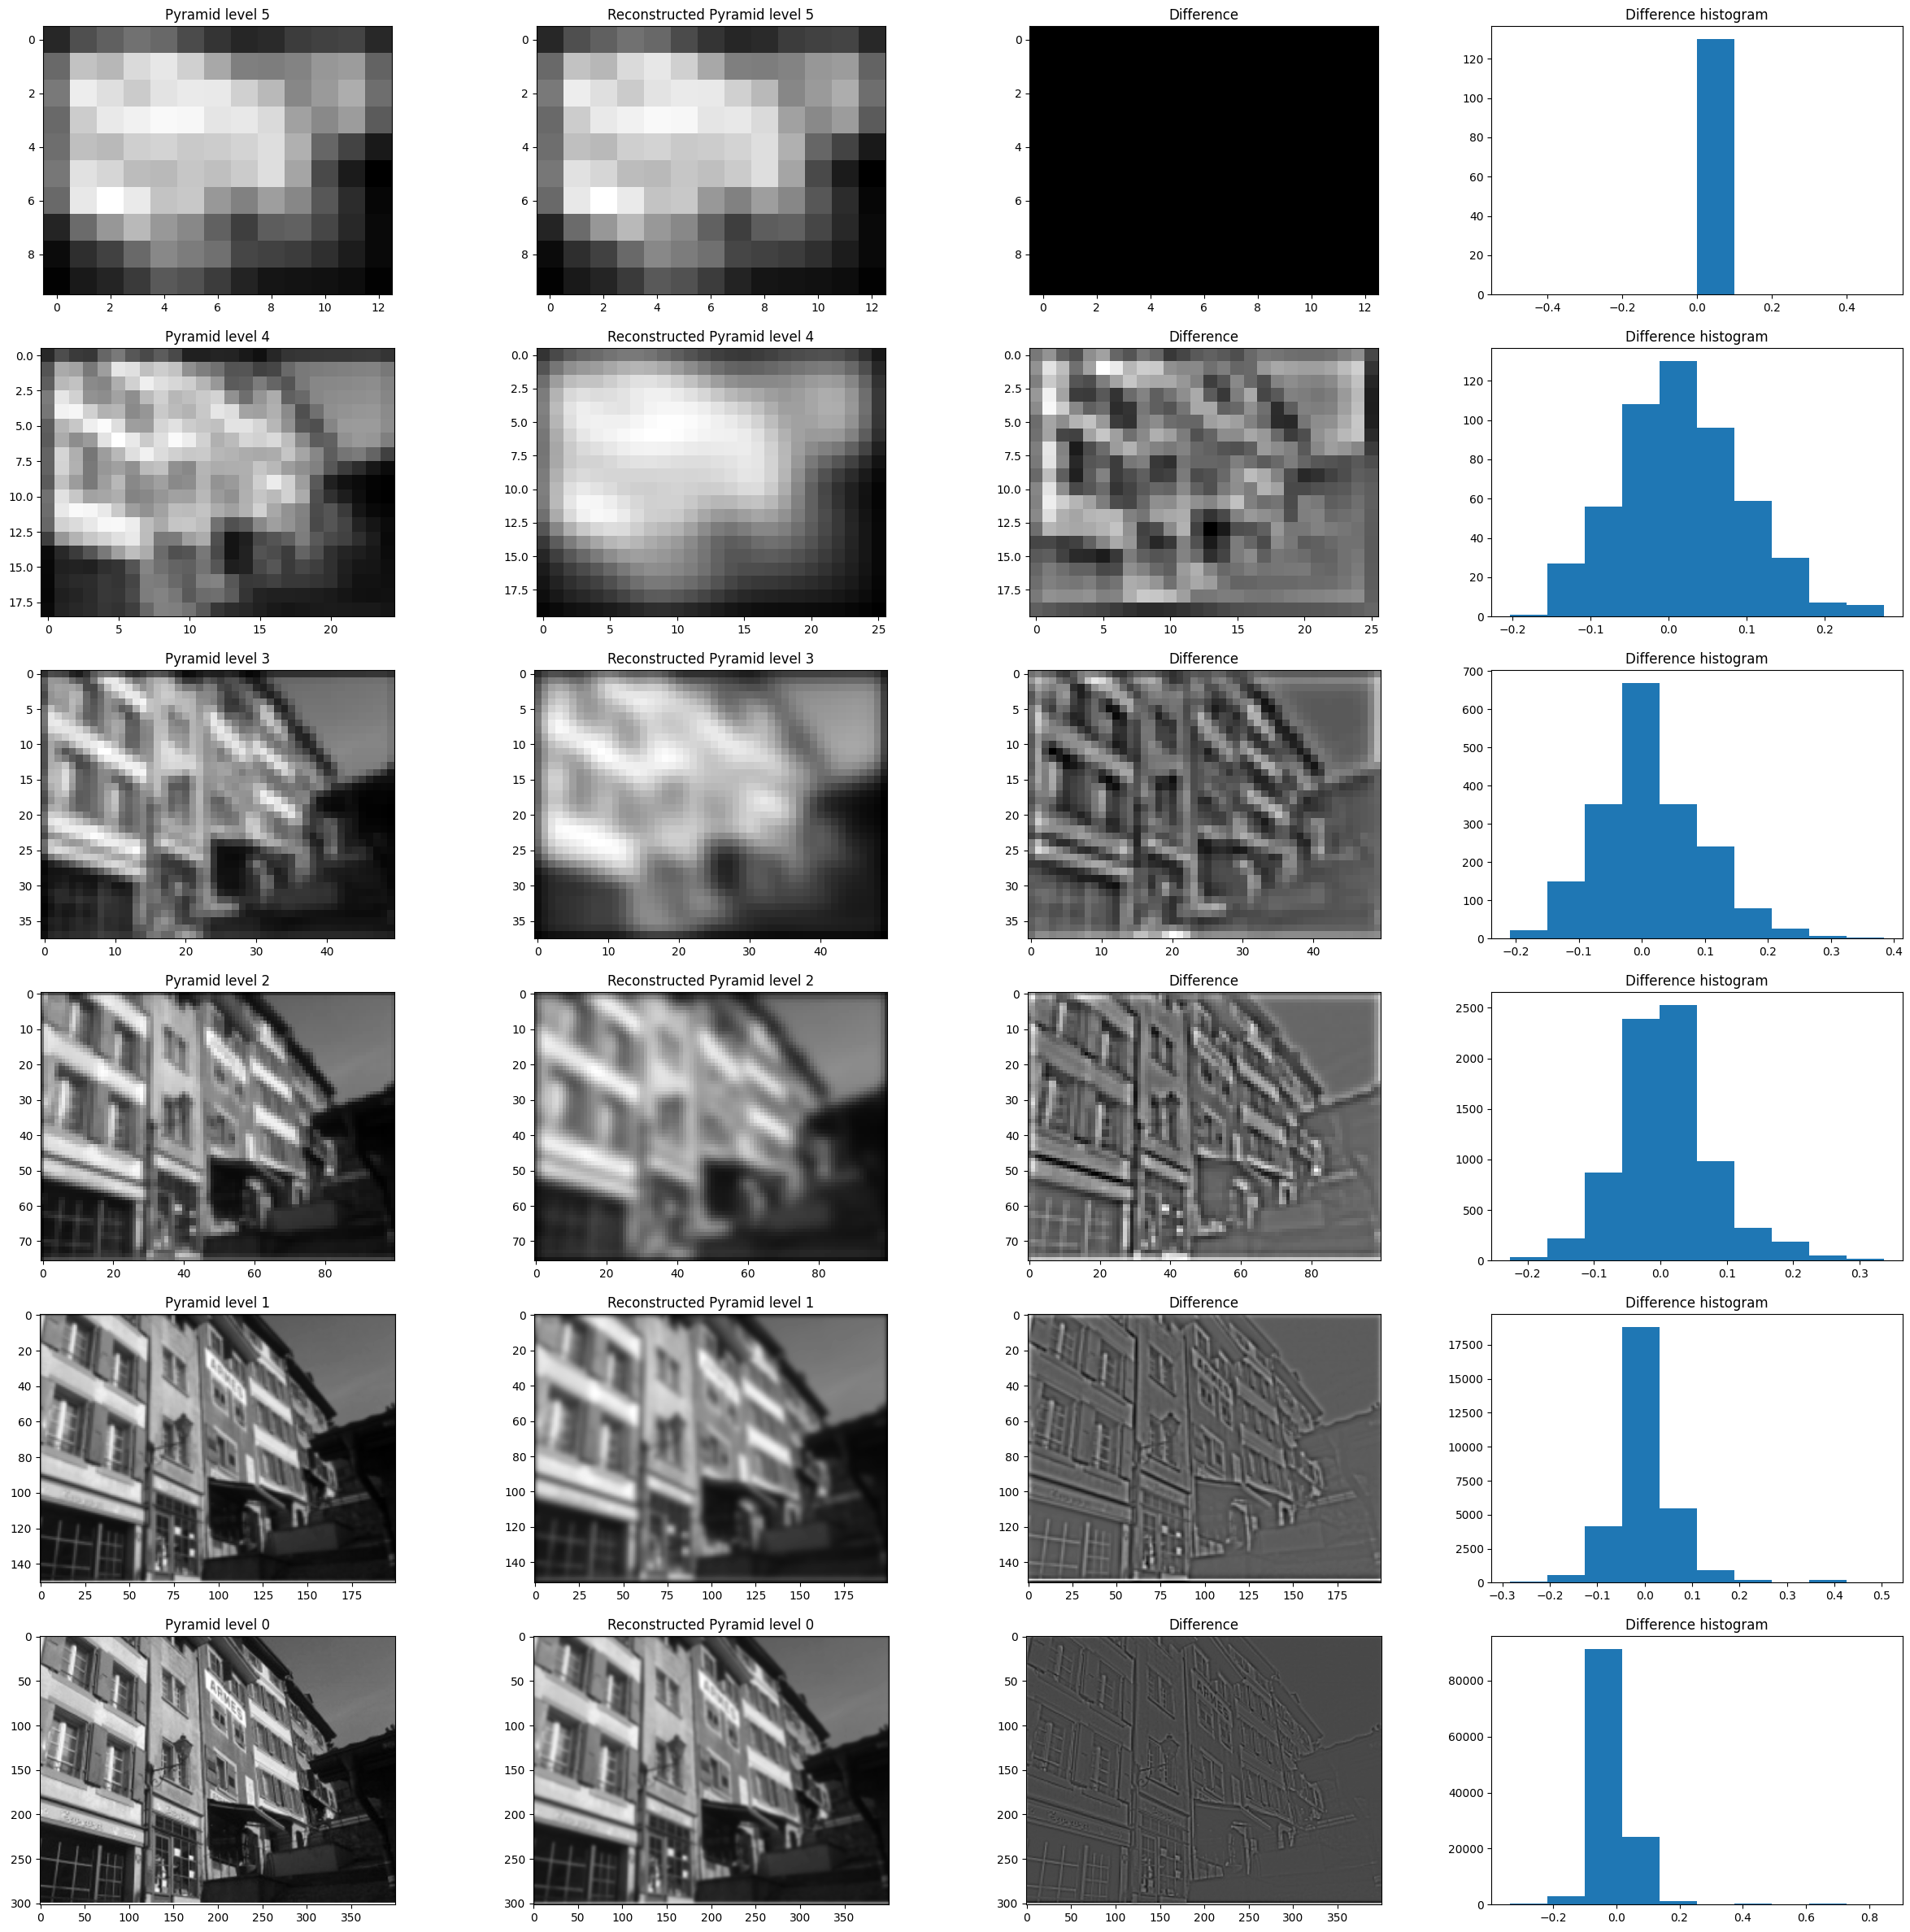

In [14]:
import scipy.signal

# Create the downsampling kernel
g = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]])/2
# Binomial, approximately Gaussian shaped.
# This is an option popularized by Burt and Adelson, See http://persci.mit.edu/pub_pdfs/pyramid83.pdf
g_2D = g.transpose()*g;      # 2D Gaussian
print('Binomial kernel of Burt and Adelson (approximately Gaussian)\n', g_2D, np.sum(g_2D))
#--------------------------------------------------------------------------

up_Gaussian_pyramid = create_up_pyramid (img, g_2D, num_levels)

#--------------------------------------------------------------------------
# Create the down pyramid by upscaling from the top of the pyramid
h = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]]) # Binomial filter used by  Burt and Adelson
hBL = h.transpose()*h;
print('Burt and Adelson Binomial interpolator\n', hBL, np.sum(hBL))
#--------------------------------------------------------------------------
down_Gaussian_pyramid = create_down_pyramid (up_Gaussian_pyramid, hBL)

#------------------display-----------------------------------------

fig, axs = plt.subplots(nrows=num_levels, ncols=4)

fig.set_size_inches (30, 30)

for i in range (num_levels) :
    axs[i, 0].imshow(up_Gaussian_pyramid[-(i+1)], 'gray')
    axs[i, 0].set_title('Pyramid level {}'.format(num_levels-i-1))

for i in range (num_levels) :
    axs[i, 1].imshow(down_Gaussian_pyramid[i], 'gray')
    axs[i, 1].set_title('Reconstructed Pyramid level {}'.format(num_levels-1-i))

for i in range (num_levels) :
    # compute error between the reconstructed images at each level from pervious levels
    reconstruction_error = padded_add (up_Gaussian_pyramid[-(i+1)], -down_Gaussian_pyramid[i])
    axs[i, 2].imshow(reconstruction_error, 'gray')
    axs[i, 2].set_title('Difference')
    axs[i, 3].hist(reconstruction_error.reshape(-1))
    axs[i, 3].set_title('Difference histogram')




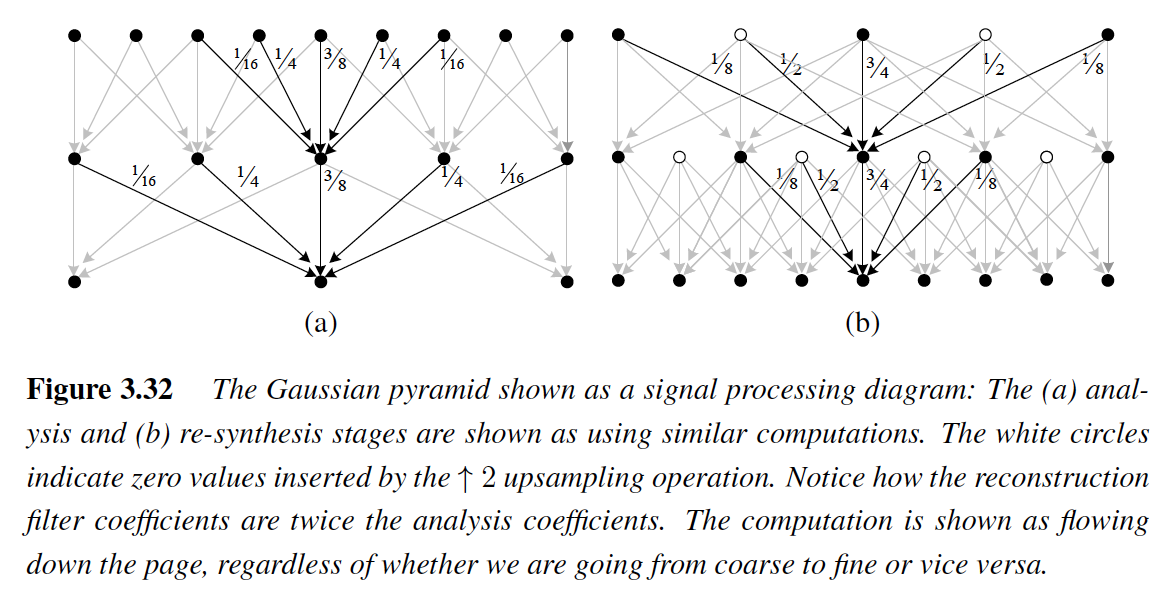

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

# Laplacian pyramid

* The difference pyramid we get when using the Gaussian pyramid is called the Laplacian pyramid, which Burt and Adelson popularized. See http://persci.mit.edu/pub_pdfs/pyramid83.pdf

* For a Gaussian pyramid, the "error" or "difference" at each level is between two Gaussian smoothed images with $\sigma$'s close to each other.

* In essence, the "difference" image is the Difference of Gaussian filtered image, which, as we have seen, looks very much like a Laplacian of Gaussian filtered image.

* Hence, we refer to the "difference" image pyramid as the "Laplacian" pyramid.


## Code: Laplacian pyramid

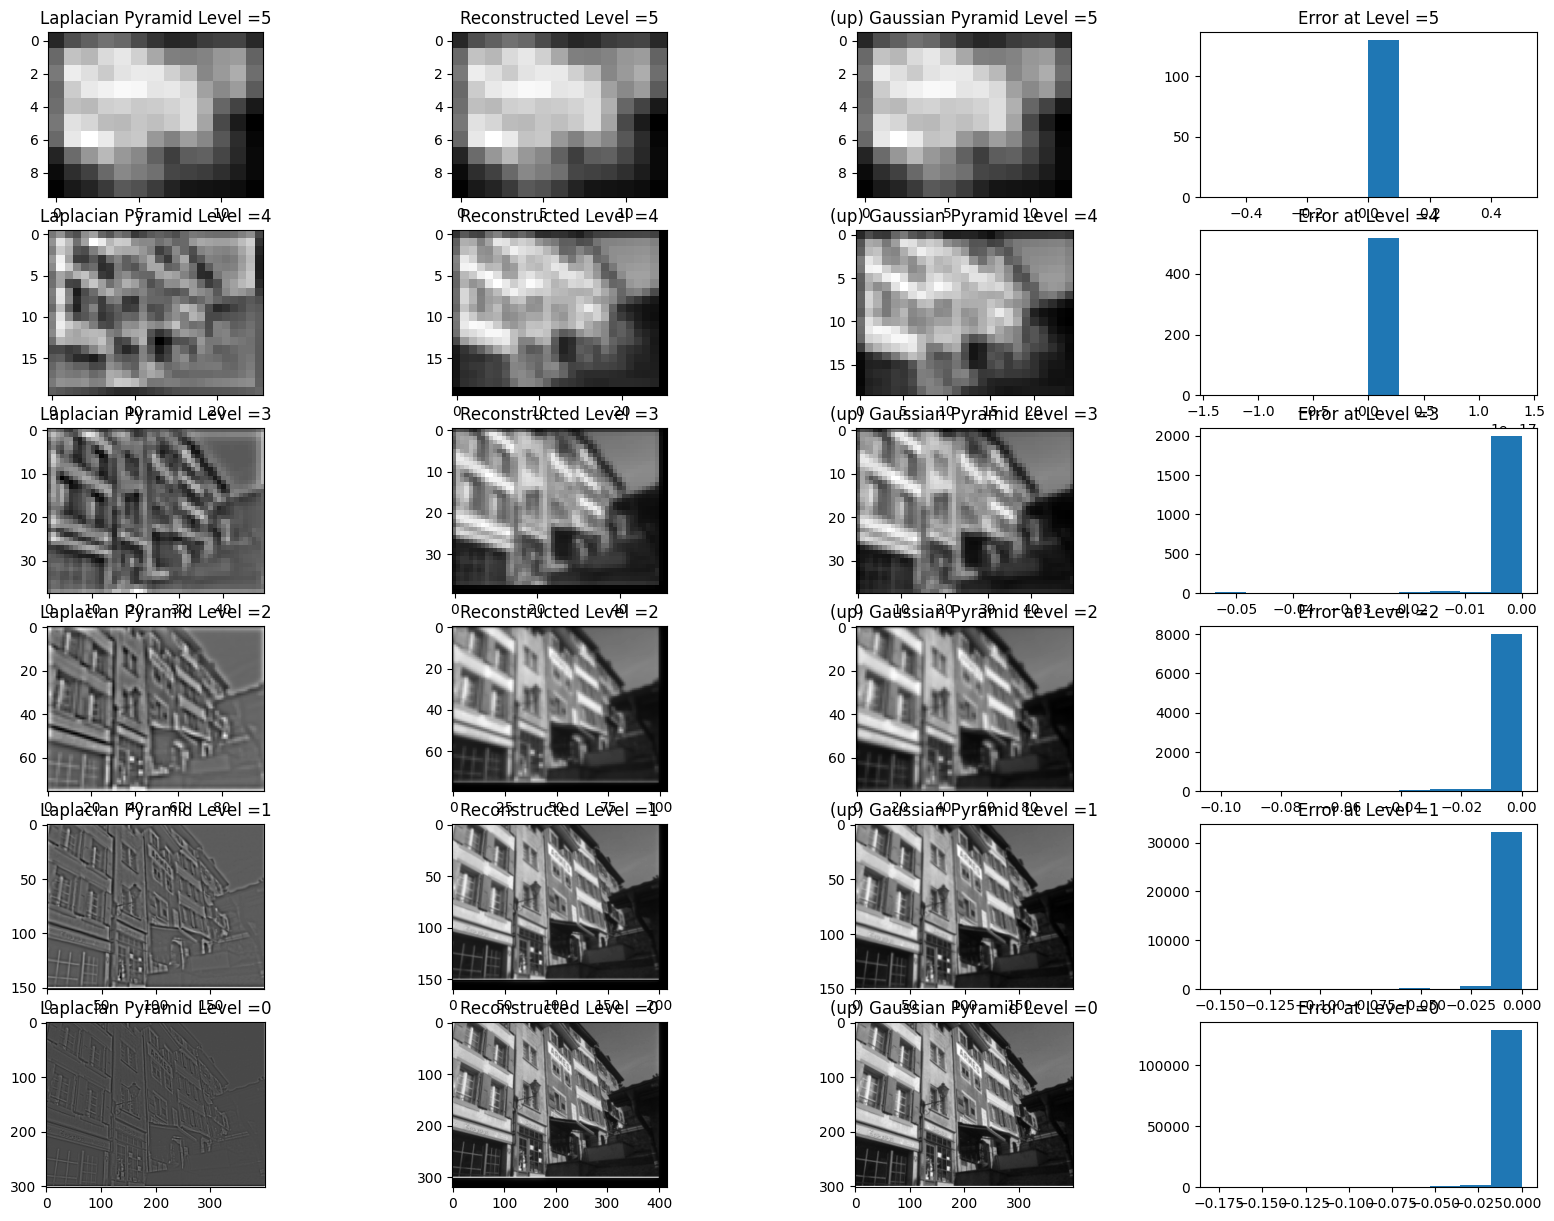

In [15]:
# Create the down pyramid by upscaling from the top of the pyramid
num_levels = 6
Laplacian_pyramid = create_difference_pyramid (up_Gaussian_pyramid, down_Gaussian_pyramid)

# Reconstruct the image pyramid
# The pyramid is stored as list:[I_hat_n, I_hat_(n-1), ...., I_hat_0] -- small to large sized.
I_hat_pyramid = []
I_hat_pyramid.append(Laplacian_pyramid[0])
for i in range (1, num_levels) :
    up_scaled_im, _ = up_sample(I_hat_pyramid[-1], kernel = hBL)
    reconstructed_image = padded_add (up_scaled_im, Laplacian_pyramid[i])
    I_hat_pyramid.append(reconstructed_image)

#------------------display-----------------------------------------

fig, axs = plt.subplots( nrows=num_levels, ncols=4) #, sharex=True, sharey=True)
fig.set_size_inches (20, 15)
for i in range (num_levels) :
    axs[i, 0].imshow(Laplacian_pyramid[i], 'gray')
    axs[i, 0].set_title('Laplacian Pyramid Level ={}'.format(num_levels-i-1))

    axs[i, 1].imshow(I_hat_pyramid[i], 'gray')
    axs[i, 1].set_title('Reconstructed Level ={}'.format(num_levels-i-1))

    axs[i, 2].imshow(up_Gaussian_pyramid[-(i+1)], 'gray')
    axs[i, 2].set_title('(up) Gaussian Pyramid Level ={}'.format(num_levels-i-1))


    axs[i, 3].hist(padded_add(up_Gaussian_pyramid[-(i+1)], - I_hat_pyramid[i]).reshape(-1))
    #axs[i, 3].imshow(padded_add(up_Gaussian_pyramid[-(i+1)], - I_hat_pyramid[i]))
    axs[i, 3].set_title('Error at Level ={}'.format(num_levels-i-1))



## Code: create_Laplacian_pyramid function

    

In [16]:
def create_Laplacian_pyramid (image, nlevels) :

    # Create the downsampling kernel
    g = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]])/2
    # Burt and Adelson Binomial kernel, approximately Gaussian shaped.
    g_2D = g.transpose()*g;      # 2D Gaussian
    #--------------------------------------------------------------------------
    up_Gaussian_pyramid = create_up_pyramid (image, g_2D, nlevels)
    #--------------------------------------------------------------------------
    # Create the down pyramid by upscaling from the top of the pyramid
    h = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]]) # Binomial filter used by  Burt and Adelson
    hBL = h.transpose()*h;
    #--------------------------------------------------------------------------
    down_Gaussian_pyramid = create_down_pyramid (up_Gaussian_pyramid, hBL)
    #--------------------------------------------------------------------------
    Laplacian_pyramid = create_difference_pyramid (up_Gaussian_pyramid, down_Gaussian_pyramid)

    return (Laplacian_pyramid)

In [17]:
def reconstruct (difference_pyramid) :
    # Reconstruct the image pyramid
    # The pyramid is stored as list:[I_hat_n, I_hat_(n-1), ...., I_hat_0] -- small to large sized.
   # Create the down pyramid by upscaling from the top of the pyramid
    h = np.array([[1/8, 1/2, 3/4, 1/2, 1/8]]) # Binomial filter used by  Burt and Adelson
    hBL = h.transpose()*h;

    I_hat_pyramid = []
    I_hat_pyramid.append(difference_pyramid[0])
    nlevels = len(difference_pyramid)
    for i in range (1, nlevels) :
        up_scaled_im, _ = up_sample(I_hat_pyramid[-1], kernel = hBL)
        reconstructed_image = padded_add (up_scaled_im, difference_pyramid[i])

        I_hat_pyramid.append(reconstructed_image)
        #print(up_scaled_im.shape, difference_pyramid[i].shape, reconstructed_image.shape)

    return(I_hat_pyramid)


## Blend Images

(302, 400)
(302, 400)


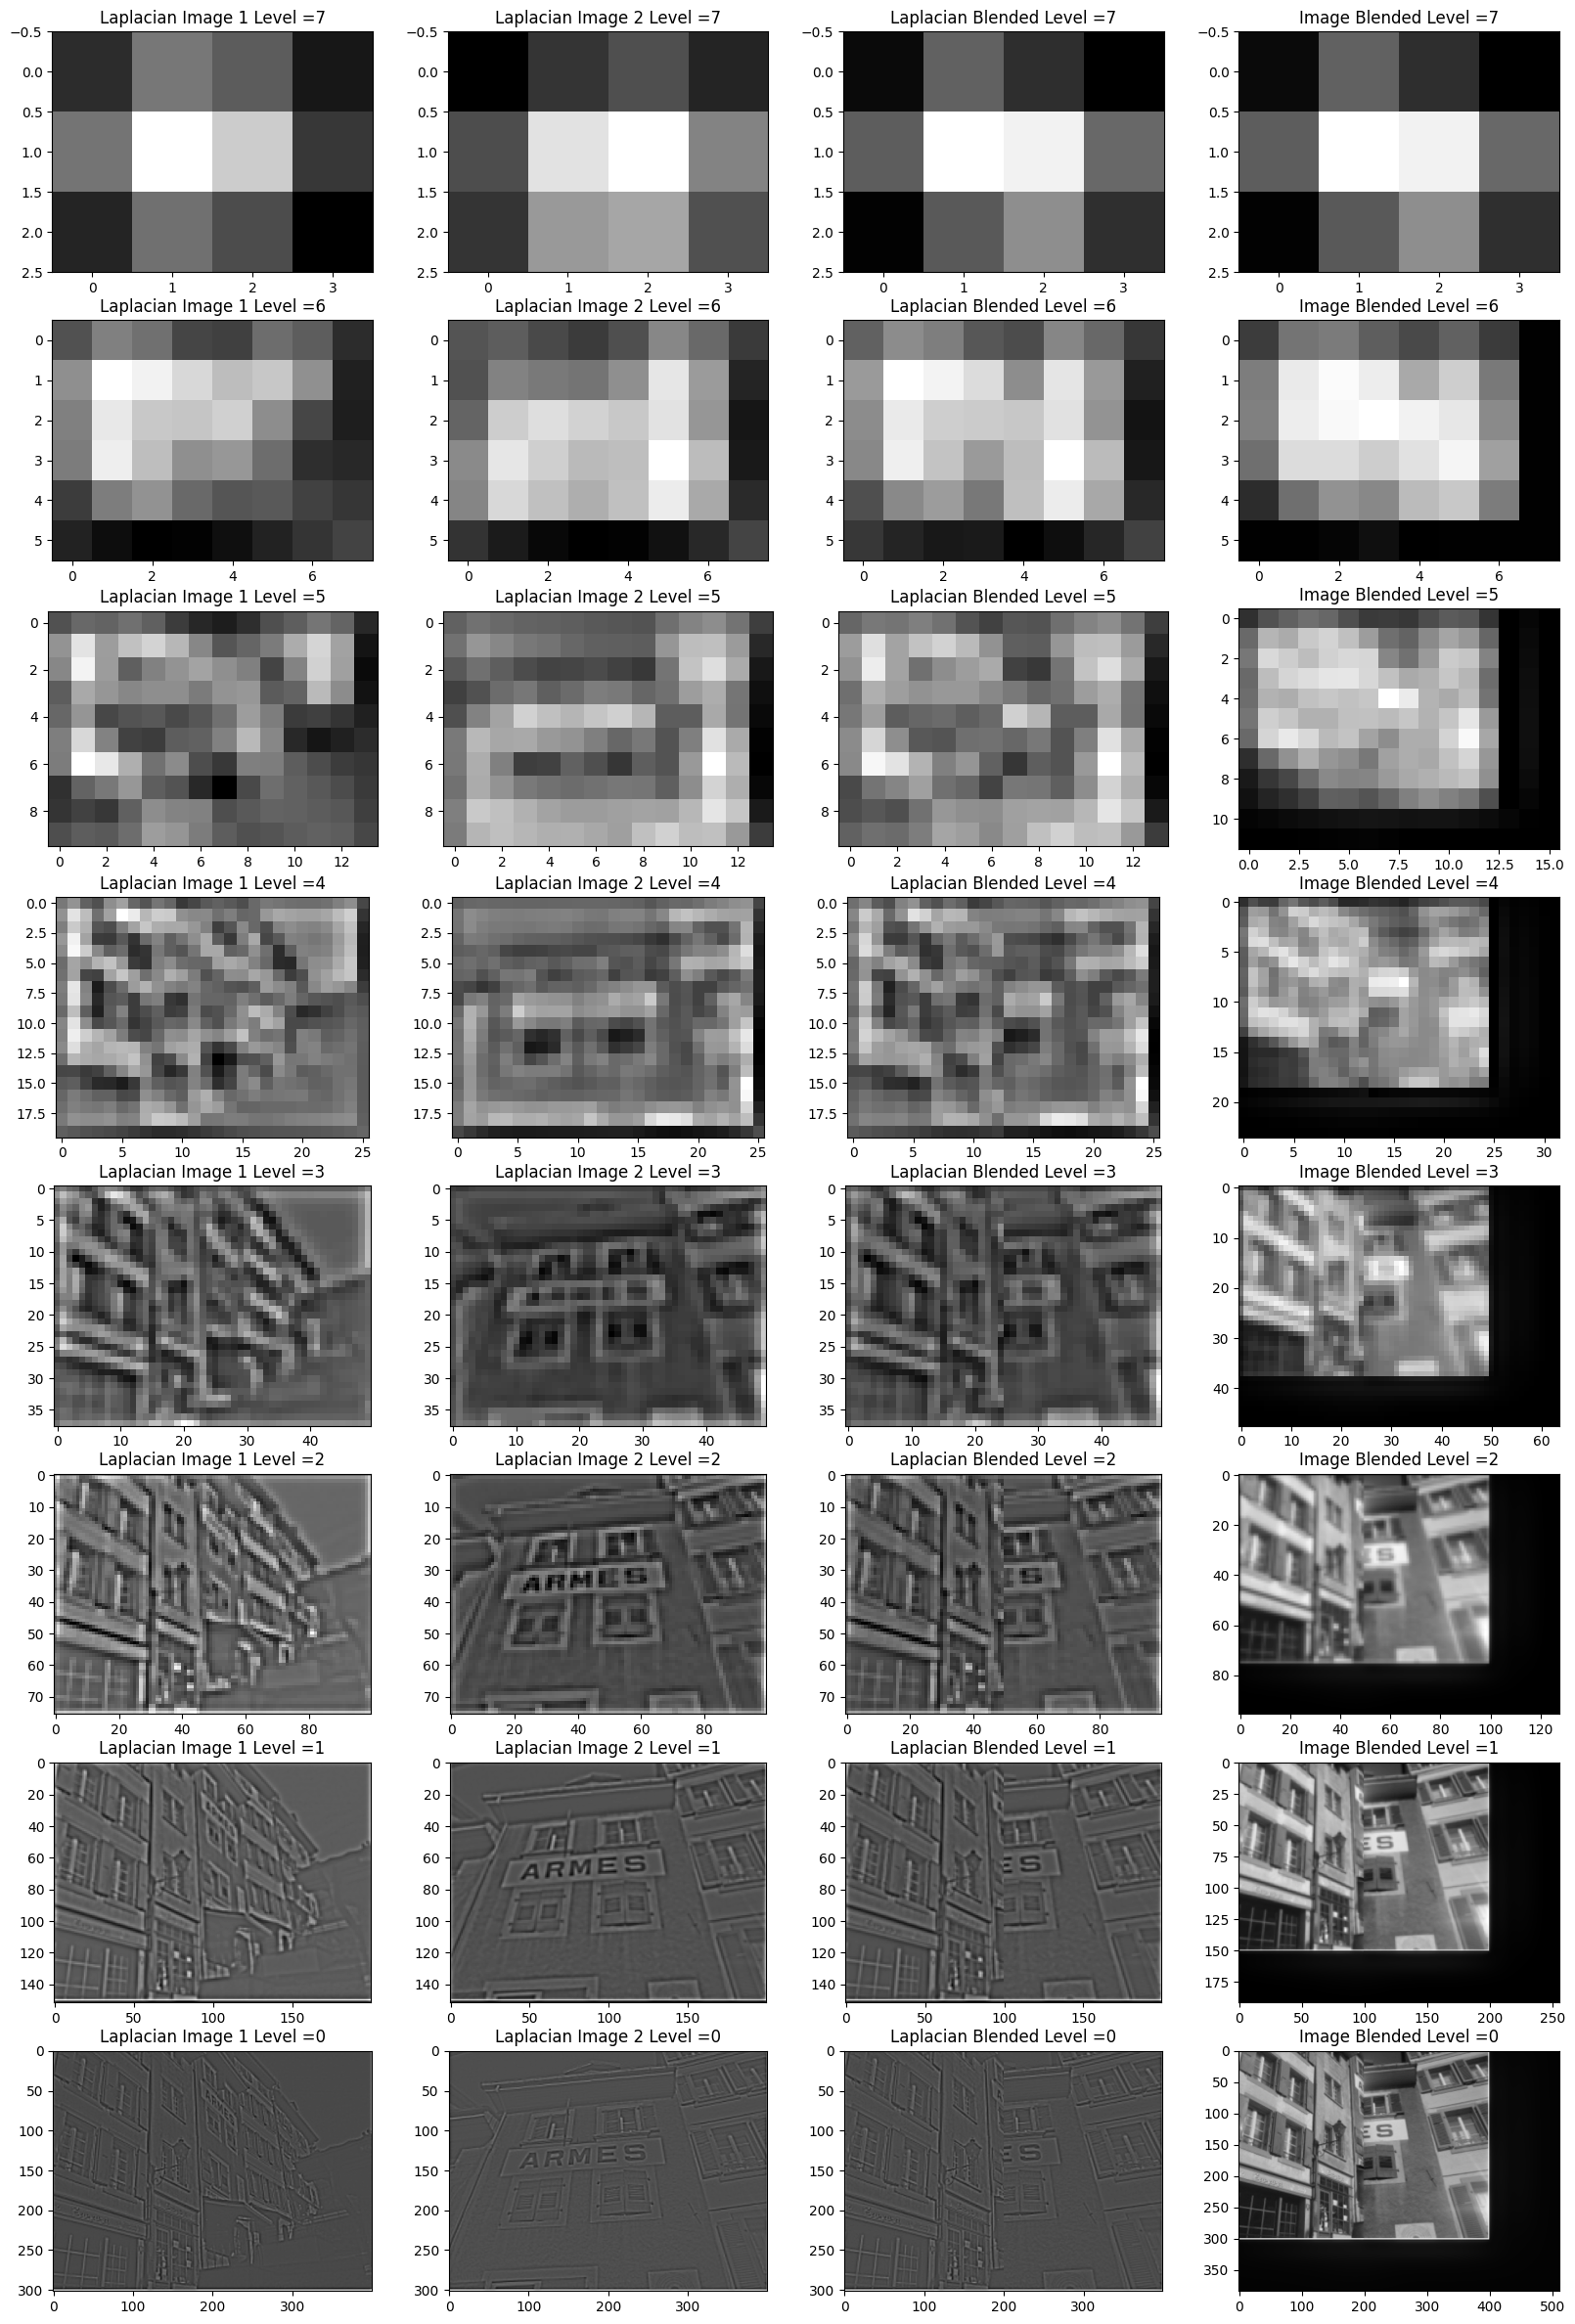

In [18]:
from skimage.transform import resize

# Load an color image in grayscale
img1 = io.imread(data_dir+'Armes 1.png')
img1 = rgb2gray(rgba2rgb(img1))
print(img1.shape)

img2 = io.imread(data_dir+'Armes 2.png')
img2 = rgb2gray(rgba2rgb(img2))
img2 = resize(img2, img1.shape)

print(img2.shape)

num_levels = 8

Laplacian_1 = create_Laplacian_pyramid (img1, nlevels = num_levels)
Laplacian_2 = create_Laplacian_pyramid (img2, nlevels = num_levels)

merged_Laplacian = []

for i in range (num_levels) :
    nR, nC = Laplacian_1[i].shape
    n = int(nC/2)
    merged = np.zeros((nR, nC))
    merged[:,0:n] = Laplacian_1[i][:,0:n]
    merged[:,n:nC] = Laplacian_2[i][:,n:nC]
    merged_Laplacian.append(merged)


blended_image = reconstruct (merged_Laplacian)
#------------------display-----------------------------------------

fig, axs = plt.subplots( nrows=num_levels, ncols=4) #, sharex=True, sharey=True)
fig.set_size_inches (20, 30)
for i in range (num_levels) :
    axs[i, 0].imshow(Laplacian_1[i], 'gray')
    axs[i, 0].set_title('Laplacian Image 1 Level ={}'.format(num_levels-i-1))

    axs[i, 1].imshow(Laplacian_2[i], 'gray')
    axs[i, 1].set_title('Laplacian Image 2 Level ={}'.format(num_levels-i-1))

    axs[i, 2].imshow(merged_Laplacian[i], 'gray')
    axs[i, 2].set_title('Laplacian Blended Level ={}'.format(num_levels-i-1))

    axs[i, 3].imshow(blended_image[i], 'gray')
    axs[i, 3].set_title('Image Blended Level ={}'.format(num_levels-i-1))


## Comparison between Laplacian blend with plain cut merge

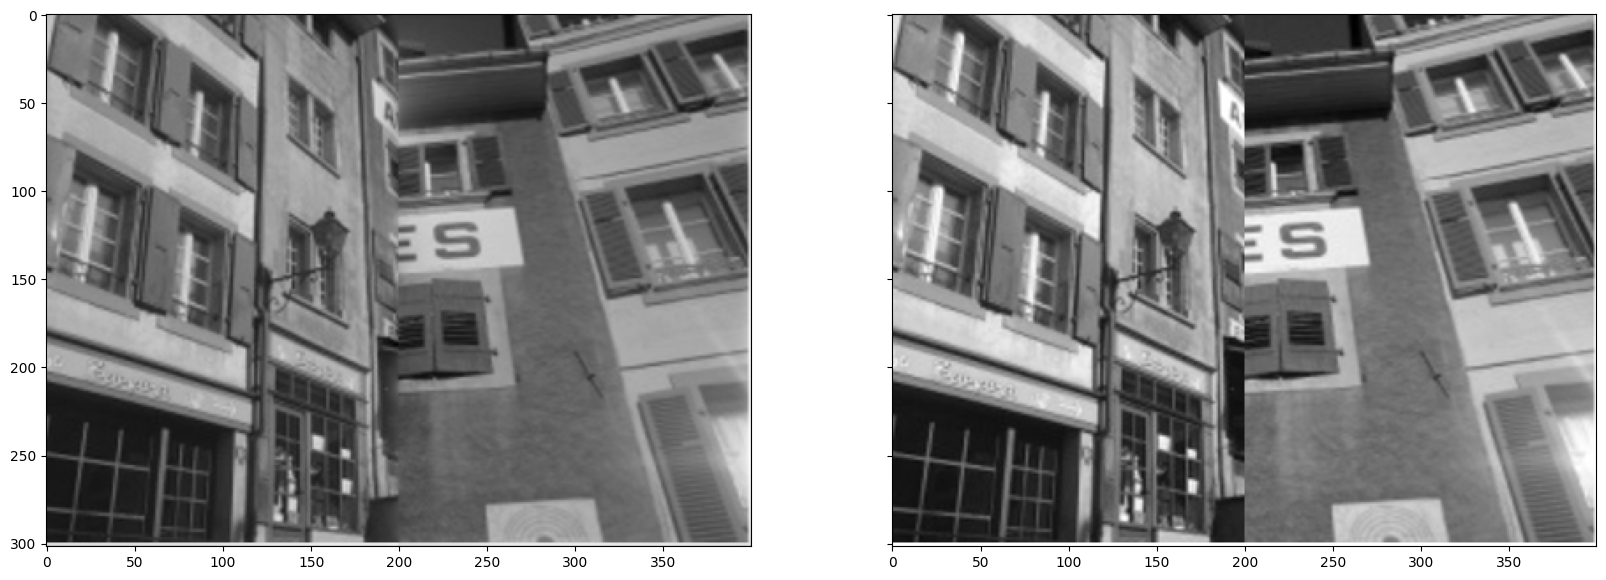

In [19]:
fig, axs = plt.subplots( nrows=1, ncols=2, sharex=True, sharey=True)
fig.set_size_inches (20, 15)

axs[0].imshow(blended_image[-1], 'gray')

nR, nC = img1.shape
n = int(nC/2)
merged = np.zeros((nR, nC))
merged[:,0:n] = img1[:,0:n]
merged[:,n:nC] = img2[:,n:nC]

axs[1].imshow(merged, 'gray');